In [53]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import jqdatasdk
from jqdatasdk import *
# jqdatasdk.auth('15357927161', 'Yg15156688441')

## 获取实时数据

In [24]:
data = get_price('IF1605.CCFX', start_date='2023-05-01', end_date='2023-05-31', frequency='minute', fields=['open', 'close', 'volume'])
data

,open,close,volume
2023-05-04 09:31:00,NaN,NaN,NaN
2023-05-04 09:32:00,NaN,NaN,NaN
2023-05-04 09:33:00,NaN,NaN,NaN
2023-05-04 09:34:00,NaN,NaN,NaN
2023-05-04 09:35:00,NaN,NaN,NaN
...,...,...,...
2023-05-30 14:56:00,NaN,NaN,NaN
2023-05-30 14:57:00,NaN,NaN,NaN
2023-05-30 14:58:00,NaN,NaN,NaN
2023-05-30 14:59:00,NaN,NaN,NaN


## 模拟一个期货的价格用于回测

In [28]:

start_date = '2023-05-01'
end_date = '2023-05-30'

date_range = pd.date_range(start=start_date, end=end_date, freq='B') 

times = pd.date_range(start='9:30', end='15:15', freq='min').time

timestamps = [pd.Timestamp(f'{date.date()} {time}') for date in date_range for time in times]

df = pd.DataFrame(index=timestamps, columns=['open'])

# Simulate Price volatility
np.random.seed(24)
amplitude = 20 
period = len(df) / 30  # Assuming 30 day is a period
noise = np.random.normal(0, 2, size=len(df))  # Adding noise

df['open'] = 1000 + amplitude * np.sin(np.linspace(0, 2 * np.pi, len(df))) + noise

# check output
print(df.head())

df.to_csv('./data/raw/Futures_Price_Simulation.csv')

                            open
2023-05-01 09:30:00  1002.658424
2023-05-01 09:31:00   998.476444
2023-05-01 09:32:00   999.400461
2023-05-01 09:33:00   998.067912
2023-05-01 09:34:00   997.924411


## 拟合策略

In [86]:
def fit_and_evaluate(df):
    if df.empty:
        return 0, 0
    # convert time with the minute as unit
    df['minutes'] = np.arange(len(df))
    
    # Second poly fitting curve
    coefficients = np.polyfit(df['minutes'], df['open'], 2)
    poly = np.poly1d(coefficients)

    # Calculate first order derivative and second order derivative value
    derivative1 = poly.deriv(1)
    derivative2 = poly.deriv(2)
    last_minute = df['minutes'].iloc[-1]
    trend = derivative1(last_minute)
    acceleration = derivative2(last_minute)
    
    # return product for signal generation
    return trend, acceleration

In [132]:
def backtest_strategy(df, start_date, end_date, window_start_time, window_end_time, end_limit_time, initial_capital=10000, commission_rate=0.0002):
    window_start = datetime.strptime(window_start_time, '%H:%M')
    window_end_initial = datetime.strptime(window_end_time, '%H:%M')
    end_limit = datetime.strptime(end_limit_time, '%H:%M')

    capital = initial_capital
    daily_records = []

    for single_date in pd.date_range(start_date, end_date):
        day_str = single_date.strftime('%Y-%m-%d')
        open_position = 0  # No position opened
        close_position_time = 0  # No close time unless a position is closed
        
        filtered_data = df.loc[day_str]
        window_end = window_end_initial
        initial_window = filtered_data.between_time(window_start.strftime('%H:%M'), window_end.strftime('%H:%M'))
        initial_trend, initial_acceleration = fit_and_evaluate(initial_window)
        
        # Check if we should open position
        if initial_trend * initial_acceleration > 0:
            if initial_trend > 0:
                open_position = 1  # Long position
                position_type = "Long"
            else:
                open_position = -1  # Short position
                position_type = "Short"

            position_open_price = initial_window.iloc[-1]['open']
            shares_owned = capital // position_open_price
            transaction_value = shares_owned * position_open_price
            commission = transaction_value * commission_rate

            if position_type == "Long":
                capital -= transaction_value + commission
            else:
                capital += transaction_value - commission
            # Reevaluate curve with every newly added data point
            while window_end < end_limit:
                window_end += timedelta(minutes=1)
                window_end_str = window_end.strftime('%H:%M')
                current_window = filtered_data.between_time(window_start.strftime('%H:%M'), window_end_str)
                current_trend, current_acceleration = fit_and_evaluate(current_window)
                
                # check if the sign of first order or second order changes.
                # if changed, we close position early
                # if not, we hold position until end_limit_time
                if current_trend * initial_trend < 0 or current_acceleration * initial_acceleration < 0:
                    ## Since we did not simulate for closing price, use open price as a temp
                    closing_price = current_window.iloc[-1]['open']
                    close_position_time = window_end_str
                    transaction_value = shares_owned * closing_price
                    commission = transaction_value * commission_rate

                    if position_type == "Long":
                        capital += transaction_value - commission
                    else:
                        capital -= transaction_value + commission

                    shares_owned = 0
                    break
            closing_price = filtered_data.iloc[-1]['open']
            close_position_time = end_limit_time
            transaction_value = shares_owned * closing_price
            commission = transaction_value * commission_rate

            if position_type == "Long":
                capital += transaction_value - commission
            else:
                capital -= transaction_value + commission
            shares_owned = 0

        profit_rate = ((capital - initial_capital) / initial_capital) * 100  # Calculate cumulative profit rate
        daily_records.append({
            "Date": day_str,
            "Open Position": open_position,
            "Close Position Time": close_position_time,
            "Cumulative Profit Rate": profit_rate,
            "Capital": capital
        })

    daily_df = pd.DataFrame(daily_records)
    return capital, daily_df


In [133]:
data = pd.read_csv('./data/raw/Futures_Price_Simulation.csv', index_col=0)
data.index = pd.to_datetime(data.index)
final_capital, daily_df = backtest_strategy(data, '2023-05-01', '2023-05-30', '09:30', '10:55', '15:15', 10000)
print("Final Capital: ", final_capital)
daily_df

Final Capital:  9658.947544800241


,Date,Open Position,Close Position Time,Cumulative Profit Rate,Capital
0,2023-05-01,-1,15:15,-0.161193,9983.880711
1,2023-05-02,-1,15:15,-0.092675,9990.732479
2,2023-05-03,-1,15:15,-0.643511,9935.648940
3,2023-05-04,-1,15:15,-1.133817,9886.618302
4,2023-05-05,1,15:15,-1.395843,9860.415733
5,2023-05-06,0,0,-1.395843,9860.415733
6,2023-05-07,0,0,-1.395843,9860.415733
7,2023-05-08,0,0,-1.395843,9860.415733
8,2023-05-09,-1,15:15,-1.245697,9875.430299
9,2023-05-10,-1,15:15,-1.338425,9866.157524


## 可视化

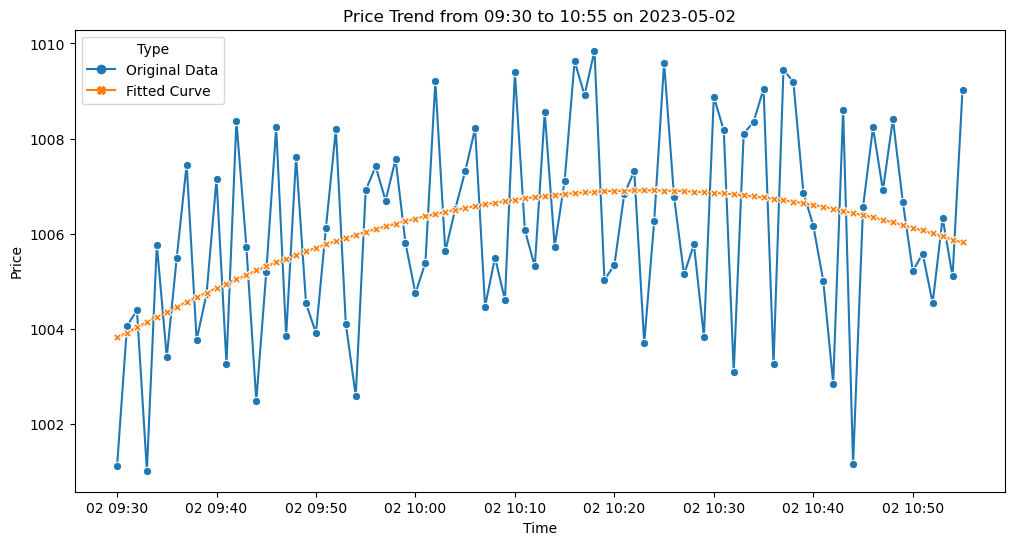

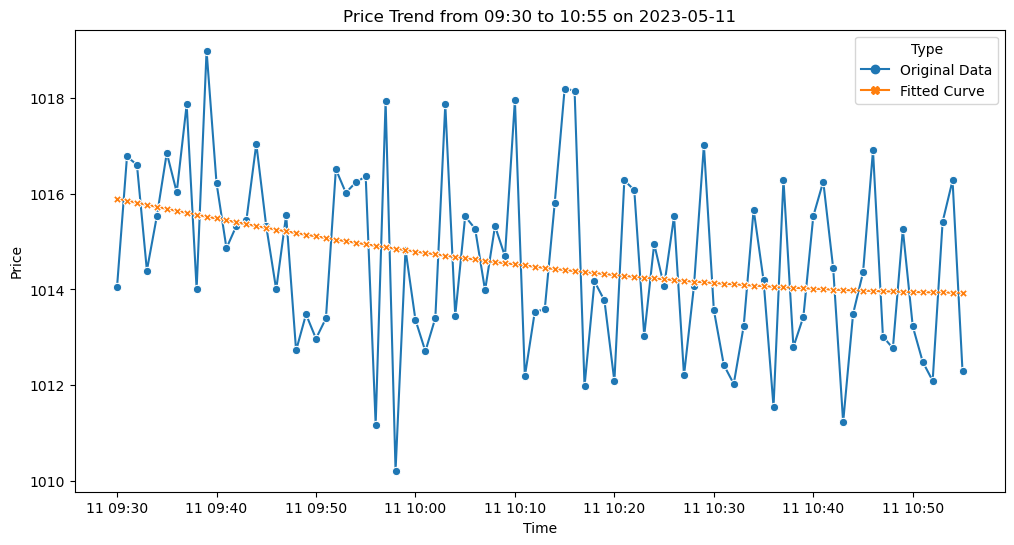

In [107]:
def plot_poly_fit(df, date, start_time, end_time, column='open'):
    # Prepare data
    df = df.loc[date]
    df = df.between_time(start_time, end_time)
    minutes = np.arange(len(df))
    prices = df[column].values

    # Fit a second-order polynomial
    coefficients = np.polyfit(minutes, prices, 2)
    poly = np.poly1d(coefficients)

    # Generate smooth data for the polynomial curve
    poly_x = np.linspace(minutes[0], minutes[-1], 300)
    poly_y = poly(poly_x)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'Time': np.concatenate([df.index, df.index[np.round(poly_x).astype(int)]]),
        'Price': np.concatenate([prices, poly_y]),
        'Type': ['Original Data']*len(prices) + ['Fitted Curve']*len(poly_y)
    })
    # Plotting with seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_df, x='Time', y='Price', hue='Type', style='Type', markers=True, dashes=False)
    plt.title(f'Price Trend from {start_time} to {end_time} on {date}')
    plt.show()
date1 = '2023-05-02'   
date2 = '2023-05-11'
start_time = '09:30'
end_time = '10:55'
plot_poly_fit(data, date1, start_time, end_time)
plot_poly_fit(data, date2, start_time, end_time)